## Ransac Iteration


1. sample n points (without replacement) from P and call the set S
2. estimate M based on S
3. calculate consensus set $S^{\ast}$ by taking all points within P which are within certain tolerance of M
4. if $S^{\ast} > t$, exit and return $S^{\ast}$ to calculate $M^{\ast}$
5. if $S^{\ast} < t$, and max number of trials is not exceeded, start over, meaning that we again sample **randomly** from P


* In the paper, they had some notes on how to select t and k (size of consensus set and mux number of iterations)
* if number of trials is exceeded, return largest consensus set found or terminate with failure

* max num selections : $k = log(1-z) / log(1 - b), b = w^n$. 
* $w$ is a probability that the data point is within tolerance, and has to be specified beforehand

* in the example above : w = 0.85, tolerance = 0.8

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from supermariopy import plotting
plotting.set_style()

In [2]:
rm *.png

rm: das Entfernen von '*.png' ist nicht möglich: Datei oder Verzeichnis nicht gefunden


In [3]:
def toy_example(n_P=20, outlier_ratio=0.1):
    x = np.linspace(0, 10, n_P)
    y = x.copy()
    n_outliers = int(n_P * outlier_ratio)
    # definition of outlier: uniform additive error model on interval [0, 10]
    
    o = np.random.uniform(-1, 1, n_outliers) * 10
    idx = np.random.choice(np.arange(n_P), n_outliers, replace=False)
    y[idx] += o
    return x, y

def original_example():
    x = np.array([0, 1, 2, 3, 3, 4, 10])
    y = np.array([0, 1, 2, 2, 3, 4, 2])
    return x, y

In [4]:
x, y = original_example()

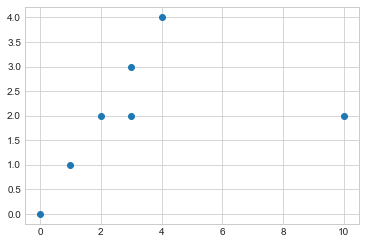

In [5]:
plt.scatter(x, y)

In [22]:
def sample_S(P, n):
    """ sample exactly n from P with p(P[i]) = 0.5 """
    idx = np.arange(len(P))
    choice = np.random.choice(idx, n, replace=False)
    S = P[choice]
    return S


def fit_model(S):
    x = S[:, 0]
    x_aug = np.stack([x, np.ones_like(x)], axis=1)
    y = S[:, 1]
    M, _, _, _ = np.linalg.lstsq(x_aug, y)
    return M


def get_consensus(M, P, tol):
    x = P[:, 0]
    y = P[:, 1]
    y_model = x * M[0] + M[1]
    residual = y - y_model
    idx_prime = np.abs(residual) < tol
    S_prime = P[idx_prime]
    return S_prime

import seaborn as sns

def iterate_ransac(P, n, t, e_tol, k = 10):
    """vanilla ransac, i.e. we sample randomly a set of n points from P"""
    # fit model
    terminate = False
    num_steps = 0
    best_S = None
    S = sample_S(P, n)
    while not terminate and num_steps < k:
        print("step ", num_steps)
        M = fit_model(S)
        S_prime = get_consensus(M, P, e_tol)
        
        print("|S*| = {}".format(len(S_prime)))
        if len(S_prime) >= t:
            print("terminating")
            best_S = S_prime
            terminate = True
            yield S, S_prime
            continue
        else:
            S_old = S.copy() # for visualization
            S = sample_S(P, n)
            if best_S is None:
                best_S = S_prime
            else:
                if len(S_prime) > len(best_S):
                    best_S = S_prime
            num_steps += 1
        yield S_old, S_prime
    return



def plot_iterations(iterations):
    colors = plotting.get_palette("custom6")
    for i, (S, S_prime) in enumerate(iterations):
        with plt.rc_context(plotting.BLOG_RC_PARAMS_5x4):
            
            # Plot P
            plt.scatter(P[:, 0], P[:, 1], label="P", s=20, zorder=3, marker="o", color=colors[0])
            A = fit_model(S)
            A_prime = fit_model(S_prime)
            
            # S, M and M with tolerance
            plt.scatter(S[:, 0], S[:, 1], label="S", s=110, zorder=1, marker="s", color=colors[1])
            plt.title("n={}, t={}, Iteration {}: ".format(n, t, i) + "sample " + r"$S$")
            
            handles, labels = plt.gca().get_legend_handles_labels()
            # sort both labels and handles by labels
            labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
            plt.legend(handles, labels, loc="upper right", ncol=2, frameon=True)
            plt.xlim([-0.3, 11])
            plt.ylim([-0.3, 6])
            plt.tight_layout()
            plt.savefig("Iteration_{:02d}_step_1.png".format(i))
            
            y_model = A[0] * P[:, 0] + A[1]
            plt.plot(P[:, 0], y_model, label="M", color=colors[1], zorder=1, linestyle="-")
            
            plt.title("n={}, t={}, Iteration {}: ".format(n, t, i)  + "fit " + r"$M$ " + "to " + r"$S$")
            handles, labels = plt.gca().get_legend_handles_labels()
            # sort both labels and handles by labels
            labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
            plt.legend(handles, labels, loc="upper right", ncol=2, frameon=True)
            plt.xlim([-0.3, 11])
            plt.ylim([-0.3, 6])
            plt.tight_layout()
            plt.savefig("Iteration_{:02d}_step_2.png".format(i))
            
            # plot S*
            plt.fill_between(P[:, 0], y_model - e_tol, y_model + e_tol, label=r"$M \pm \epsilon$", color=colors[1], alpha=0.1, zorder=-1)
            plt.scatter(S_prime[:, 0], S_prime[:, 1], label="S*", s=70, zorder=2, marker="o", color=colors[3])

            
            plt.title("n={}, t={}, Iteration {}: ".format(n, t, i)  + "get consensus set " r"$S^{\ast}$")
            handles, labels = plt.gca().get_legend_handles_labels()
            # sort both labels and handles by labels
            labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
            plt.legend(handles, labels, loc="upper right", ncol=2, frameon=True)
            plt.xlim([-0.3, 11])
            plt.ylim([-0.3, 6])
            plt.tight_layout()
            plt.savefig("Iteration_{:02d}_step_3.png".format(i))
            
            if len(S_prime) >= t:
                plt.plot(P[:, 0], A_prime[0] * P[:, 0] + A_prime[1], label="M*", color=colors[3], zorder=1, linestyle="--")
                plt.title("n={}, t={}, Iteration {}: ".format(n, t, i)  + r"$|S^{\ast}| \geq t$, " + "terminate")
                handles, labels = plt.gca().get_legend_handles_labels()
                # sort both labels and handles by labels
                labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
                plt.legend(handles, labels, loc="upper right", ncol=2, frameon=True)
                plt.xlim([-0.3, 11])
                plt.ylim([-0.3, 6])
                plt.tight_layout()
                plt.savefig("Iteration_{:02d}_step_4.png".format(i))
            else:
                plt.title("n={}, t={}, Iteration {}: ".format(n, t, i)  + "start over")
                handles, labels = plt.gca().get_legend_handles_labels()
                # sort both labels and handles by labels
                labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
                plt.legend(handles, labels, loc="upper right", ncol=2, frameon=True)
                plt.xlim([-0.3, 11])
                plt.ylim([-0.3, 6])
                plt.tight_layout()
                plt.savefig("Iteration_{:02d}_step_5.png".format(i))
            
            plt.close()
    

## Run 3 times with different initializations

In [23]:
np.random.seed(42)

P = np.stack([x, y], axis=1)
n = 3
initial_S = sample_S(P, n)
t = 4 # minimum size of consensus set
e_tol = 0.8
k = 20
iterations = list(iterate_ransac(P, n, t, e_tol, k))
plot_iterations(iterations)

!mkdir seed_42
!mv *.png seed_42

np.random.seed(41)

P = np.stack([x, y], axis=1)
n = 3
initial_S = sample_S(P, n)
t = 4 # minimum size of consensus set
e_tol = 0.8
k = 20
iterations = list(iterate_ransac(P, n, t, e_tol, k))
plot_iterations(iterations)
!mkdir seed_41
!mv *.png seed_41

np.random.seed(40)
P = np.stack([x, y], axis=1)
n = 3
initial_S = sample_S(P, n)
t = 4 # minimum size of consensus set
e_tol = 0.8
k = 20
iterations = list(iterate_ransac(P, n, t, e_tol, k))
plot_iterations(iterations)
!mkdir seed_40
!mv *.png seed_40

step  0
|S*| = 6
terminating


/home/sandro/anaconda3/envs/py37_tfpt/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  del sys.path[0]
/home/sandro/anaconda3/envs/py37_tfpt/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  del sys.path[0]


mkdir: das Verzeichnis »seed_42“ kann nicht angelegt werden: Die Datei existiert bereits
step  0
|S*| = 4
terminating


/home/sandro/anaconda3/envs/py37_tfpt/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  del sys.path[0]


mkdir: das Verzeichnis »seed_41“ kann nicht angelegt werden: Die Datei existiert bereits
step  0
|S*| = 5
terminating


/home/sandro/anaconda3/envs/py37_tfpt/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  del sys.path[0]


mkdir: das Verzeichnis »seed_40“ kann nicht angelegt werden: Die Datei existiert bereits


## run with smaller n

In [24]:
np.random.seed(42)

P = np.stack([x, y], axis=1)
n = 3
initial_S = sample_S(P, n)
t = 5 # minimum size of consensus set
e_tol = 0.8
k = 20
iterations = list(iterate_ransac(P, n, t, e_tol, k))
plot_iterations(iterations)

!mkdir seed_42_n2_t5
!mv *.png seed_42_n2_t5

np.random.seed(41)

P = np.stack([x, y], axis=1)
n = 3
initial_S = sample_S(P, n)
t = 5 # minimum size of consensus set
e_tol = 0.8
k = 20
iterations = list(iterate_ransac(P, n, t, e_tol, k))
plot_iterations(iterations)
!mkdir seed_41_n2_t5
!mv *.png seed_41_n2_t5

np.random.seed(40)
P = np.stack([x, y], axis=1)
n = 3
initial_S = sample_S(P, n)
t = 5 # minimum size of consensus set
e_tol = 0.8
k = 20
iterations = list(iterate_ransac(P, n, t, e_tol, k))
plot_iterations(iterations)
!mkdir seed_40_n2_t5
!mv *.png seed_40_n2_t5

step  0
|S*| = 6
terminating


/home/sandro/anaconda3/envs/py37_tfpt/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  del sys.path[0]
/home/sandro/anaconda3/envs/py37_tfpt/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  del sys.path[0]


mkdir: das Verzeichnis »seed_42_n2_t5“ kann nicht angelegt werden: Die Datei existiert bereits
step  0
|S*| = 4
updating consenus set
step  1
|S*| = 5
terminating


/home/sandro/anaconda3/envs/py37_tfpt/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  del sys.path[0]
/home/sandro/anaconda3/envs/py37_tfpt/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  del sys.path[0]


mkdir: das Verzeichnis »seed_41_n2_t5“ kann nicht angelegt werden: Die Datei existiert bereits
step  0
|S*| = 5
terminating


/home/sandro/anaconda3/envs/py37_tfpt/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  del sys.path[0]


mkdir: das Verzeichnis »seed_40_n2_t5“ kann nicht angelegt werden: Die Datei existiert bereits


In [25]:
!for d in seed_*/; do cd $d; convert -delay 200 -loop 0 *.png animation.gif; cd ..; done

move animations to pardir so that zim export works

In [6]:
import shutil, os, glob

In [14]:
for gif_file in glob.glob("seed_*/animation.gif"):
    dirname = os.path.dirname(gif_file)
    basename = os.path.basename(gif_file)
    shutil.copyfile(gif_file, "_".join([dirname,basename]))